# Chapter 18

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master//chapters/chap18.ipynb)

The previous chapter presents the minimal model of the glucose-insulin system and introduces a tool we will need to implement it, interpolation.

In this chapter, we'll implement the model two ways:

* We'll start by rewriting the differential equations as difference equations; then we'll solve the difference equations using a version of `run_simulation` similar to what we have used in previous chapters.

* Then we'll use a new SciPy function, called `solve_ivp`, to solve the differential equation using a better algorithm.

We'll see that `solve_ivp` is faster and more accurate than `run_simulation`.
As a result, we will use it for the models in the rest of the book.

The following cell downloads the data.

In [4]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

We can use Pandas to read the data.

In [5]:
from pandas import read_csv

data = read_csv('glucose_insulin.csv', index_col='time');

## Implementing the Model

To get started, let's assume that the parameters of the model are known.
We'll implement the model and use it to generate time series for `G` and `X`. 
Then we'll see how we can choose parameters that make the simulation fit the data.

Here are the parameters.

In [6]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

I'll put these values in a sequence which we'll pass to `make_system`:

In [7]:
params = G0, k1, k2, k3

Here's a version of `make_system` that takes `params` and `data` as parameters.

In [8]:
def make_system(params, data):
    G0, k1, k2, k3 = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    I = interpolate(data.insulin)
    
    init = State(G=G0, X=0)
    
    return System(init=init, params=params,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

`make_system` gets `t_0` and `t_end` from the data. 
It uses the measurements at `t=0` as the basal levels, `Gb` and `Ib`. 
And it uses the parameter `G0` as the initial value for `G`. Then it 
packs everything into a `System` object.

In [9]:
system = make_system(params, data)

## The Update Function

The minimal model is expressed in terms of differential equations:

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

To simulate this system, we will rewrite them as difference equations. 
If we multiply both sides by $dt$, we have:

$$dG = \left[ -k_1 \left[ G(t) - G_b \right] - X(t) G(t) \right] dt$$

$$dX = \left[ k_3 \left[I(t) - I_b \right] - k_2 X(t) \right] dt$$ 

If we think of $dt$ as a small step in time, these equations tell us how to compute the corresponding changes in $G$ and $X$.

Here's an update function that computes these changes:

In [10]:
def update_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

As usual, the update function takes a time stamp, a `State` object, and a `System` object as parameters. The first line uses multiple assignment to extract the current values of `G` and `X`.

The following lines unpack the parameters we need from the `System`
object.

To compute the derivatives `dGdt` and `dXdt` we translate the equations from math notation to Python.
Then, to perform the update, we multiply each derivative by the time step `dt`, which is 2 min in this example. 

The return value is a `State` object with the new values of `G` and `X`.

Before running the simulation, it is a good idea to run the update
function with the initial conditions:

In [11]:
update_func(system.t_0, system.init, system)

G    262.88
X      0.00
Name: state, dtype: float64

If it runs without errors and there is nothing obviously wrong with the results, we are ready to run the simulation. 

## The Simulation

We'll use the following version of `run_simulation`:

In [12]:
def run_simulation(system, update_func):    
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    frame = TimeFrame(index=t_array, 
                      columns=system.init.index)
    frame.iloc[0] = system.init
    
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)
    
    return frame

This version is similar to the one we used for the coffee cooling problem.
The biggest difference is that it makes and returns a `TimeFrame` rather than a `TimeSeries`.

When we make the `TimeSeries`, we use `index` to indicate that the index is the array of time stamps, `t_array`, and `columns` to indicate that the column names are the state variables we get from `init`.

We can run it like this:

In [13]:
results = run_simulation(system, update_func)

The result is a `TimeFrame` with a row for each time step and a column for each of the state variables, `G` and `X`.
Here are the first few time steps.

In [14]:
results.head()

,G,X
0.0,270.000000,0.000000
2.0,262.880000,0.000000
4.0,256.044800,0.000450
6.0,249.252568,0.004002
8.0,240.967447,0.006062


The following plot shows the simulated glucose levels from the model along with the measured data. 

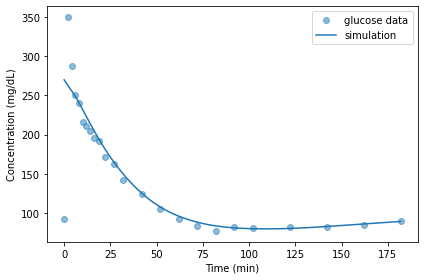

In [15]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data')
results.G.plot(style='-', color='C0', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

With the parameters I chose, the model fits the data well except during the first few minutes after the injection.
But we don't expect the model to do well in this regime.

The problem is that the model is **non-spatial**; that is, it does not
take into account different concentrations in different parts of the
body. Instead, it assumes that the concentrations of glucose and insulin in blood, and insulin in tissue fluid, are the same throughout the body. This way of representing the body is known among experts as the "bag of blood" model.

Immediately after injection, it takes time for the injected glucose to
circulate. During that time, we don't expect a non-spatial model to be
accurate. For this reason, we should not take the estimated value of `G0` too seriously; it is useful for fitting the model, but not meant to correspond to a physical, measurable quantity.

The following plot shows simulated insulin levels in the hypothetical "remote compartment", which is in unspecified units.

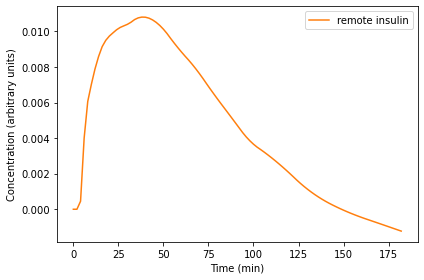

In [16]:
results.X.plot(color='C1', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

Remember that `X` represents the concentration of insulin in the "remote compartment", which is believed to be tissue fluid, so we can't compare it to the measured concentration of insulin in the blood.

`X` rises quickly after the initial injection and then declines as the concentration of glucose declines.  Qualitatively, this behavior is as expected, but because `X` is not an observable quantity, we can't validate this part of the model quantitatively.

## Solving differential equations

To implement the minimal model, we rewrote the differential equations as difference equations with a finite time step, `dt`.

When $dt$ is very small, or more precisely **infinitesimal**, the difference equations are the same as the differential equations.
But in our simulations, $dt$ is 2 min, which is not very small, and definitely not infinitesimal. 

In effect, the simulations assume that the derivatives $dG/dt$ and $dX/dt$ are constant during each 2 min time step.
This method, evaluating derivatives at discrete time steps and assuming that they are constant in between, is called **Euler's method** (see <http://modsimpy.com/euler>).

Euler's method is good enough for many problems, but sometimes it is not very accurate.
In that case, we can usually make it more accurate by decreasing the size of `dt`.
But then it is not very efficient.

There are other methods that are more accurate and more efficient than Euler's method.
SciPy provides several of them wrapped in a function called `solve_ivp`.
The "ivp" in `solve_ivp` stands for "initial value problem", which is the term for problems like the ones we've been solving, where we are given the initial conditions and try to predict what will happen.

The ModSim library provides a function called `run_solve_ivp` that makes `solve_ivp` a little easier to use.

To use it, we have to provide a "slope function", which is similar to an update function; in fact, it takes the same parameters: a time stamp, a `State` object, and a `System` object.

Here's a slope function that evaluates the differential equations of the minimal model.

In [17]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

`slope_func` is a little simpler than `update_func` because it only compute the derivatives, that is, the slopes. It doesn't do the updates; the solver does them for us.

Now we can call `run_solve_ivp` like this:

In [18]:
results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=results.index)

`run_solve_ivp` is similar to `run_simulation`: it takes a `System`
object and a slope function as parameters.

The third argument, `t_eval`, is optional; it specifies where the solution should be evaluated.

It returns two values: a `TimeFrame`, which we assign to `results2`, and an `OdeResult` object, which we assign to `details`.

The `OdeResult` object contains information about how the solver ran, including a success code and a diagnostic message.

In [19]:
details.success

True

In [20]:
details.message

'The solver successfully reached the end of the integration interval.'

It's important to check these messages after running the solver, in case anything went wrong.

The `TimeFrame` has one row for each time step and one column for each state variable. In this example, the rows are time from 0 to 182 minutes; the columns are the state variables, `G` and `X`.
Here are the first few time steps:

In [21]:
results2.head()

,G,X
0.0,270.000000,0.000000
2.0,262.980942,0.000240
4.0,255.683455,0.002525
6.0,247.315442,0.005174
8.0,238.271851,0.006602


Because we used `t_eval=results.index`, the time stamps in `results2` are the same as in `results`, which makes them easier to compare.

The following figure shows the results from `run_solve_ivp` along with the results from `run_simulation`:

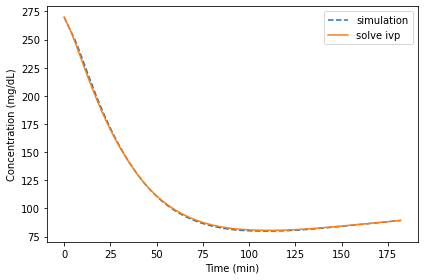

In [22]:
results.G.plot(style='--', label='simulation')
results2.G.plot(style='-', label='solve ivp')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

The differences are barely visible.
We can compute the relative differences like this:



In [23]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100

And we can use `describe` to compute summary statistics:

In [24]:
percent_diff.abs().describe()

count    92.000000
mean      0.649121
std       0.392903
min       0.000000
25%       0.274854
50%       0.684262
75%       1.009868
max       1.278168
Name: G, dtype: float64

The mean relative difference is about 0.65%;
the maximum is a little more than 1%.
So in this example, the results from Euler's method are probably good enough for practical purposes.

Here are the results for `X`.

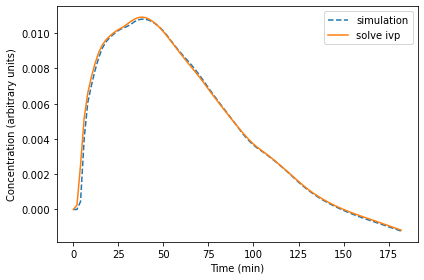

In [25]:
results.X.plot(style='--', label='simulation')
results2.X.plot(style='-', label='solve ivp')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

These differences are little bigger, especially at the beginning.
As an exercise, you can experiment with `dt` and see what effect it has on these results.

In [26]:
diff = results.G - results2.X
percent_diff = diff / results2.X * 100
percent_diff.abs().describe()

count    9.200000e+01
mean              inf
std               NaN
min      1.095267e+06
25%      1.362916e+06
50%      2.442010e+06
75%      9.517750e+06
max               inf
dtype: float64

## Summary

In this chapter, we implemented the glucose minimal model two ways, using `run_simulation` and `run_solve_ivp`, and compared the results.
We found that in this example, `run_simulation`, which uses Euler's method, is probably good enough.
But soon we will see examples where it is not.

So far, we have assumed that the parameters of the system are known, but in practice that's not true.
As one of the case studies in the next chapter, you'll have a chance to see where those parameters came from.

## Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

In [27]:
# Solution

system3 = system.set(dt = 1)
results3 = run_simulation(system3, update_func)

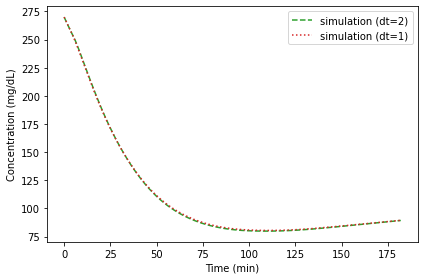

In [28]:
# Solution

results.G.plot(style='C2--', label='simulation (dt=2)')
results3.G.plot(style='C3:', label='simulation (dt=1)')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [29]:
# Solution

diff = results.G - results3.G
percent_diff = diff / results3.G * 100
percent_diff.abs().describe()

count    92.000000
mean      0.527015
std       0.291531
min       0.000000
25%       0.292193
50%       0.505702
75%       0.801698
max       0.970760
Name: G, dtype: float64